## Homework 5: Mixed-effects models

In this homework we will continue analyzing the lexical decision data from Homework 4. 

We will be using the files `ldt_trials.csv` and `word_properties.csv` in the `data` folder. These files contain lexical decision reaction times for each participant and each word (`ldt_trials.csv`) and information about various word properties such as word length, word frequency, concreteness and emotional valence (`word_properties.csv`). These data were obtained from the English Lexicon Project: https://elexicon.wustl.edu/index.html

#### Part 1: Loading and organizing the data

Load the two datasets and repeat all preprocessing steps from Homework 4. You should end up with a dataset of 35978 rows.

In [13]:
library(tidyverse)

ldt_trials <- read.csv('Homeworks/data/ldt_trials.csv')
word_properties <- read.csv('Homeworks/data/word_properties.csv')

df1 <- left_join(ldt_trials, word_properties, by=c("D_word"="Word"))  %>% 
    filter(!is.na(Length))

head(df1)
nrow(df1)

,Sub_ID,Trial,Type,D_Accuracy,D_RT,D_word,Outlier,D_Zscore,Length,SUBTLWF,Concreteness_Rating,Emotional_Valence
,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,85,85,1,1,541,healthy,0,-0.849372,7,24.75,3.31,7.76
2,85,86,1,1,1215,loony,0,1.535949,5,2.41,2.15,4.48
3,85,89,1,1,677,cart,0,-0.368061,4,9.04,4.89,5.37
4,85,100,1,1,659,blunt,0,-0.431764,5,4.90,3.07,4.65
5,85,101,1,1,532,thousand,0,-0.881224,8,69.29,3.08,6.44
6,85,111,1,1,597,lyrics,0,-0.651186,6,5.08,3.86,6.42


[1] 35978

Transform the Sub_ID variable into a factor using the `as.factor()` command:

In [14]:
df1$Sub_ID <- as.factor(df1$Sub_ID)

#### Part 2: Plot the effect of Length on RTs separately for each participant

In Homework 4 we saw that lexical decision RTs increase as a function of word length by approximately 26 ms per letter. This is the overall effect, but it's likely that the effect varies across participants. First, let's try to do some plots to understand this better.

First, plot the overall effect of word length on RTs. Use the `stat_summary()` command to summarize the Y variable for each X value. Then use the `geom_smooth(method='lm', se=F)` command to plot a linear regression line through the data.

No summary function supplied, defaulting to `mean_se()



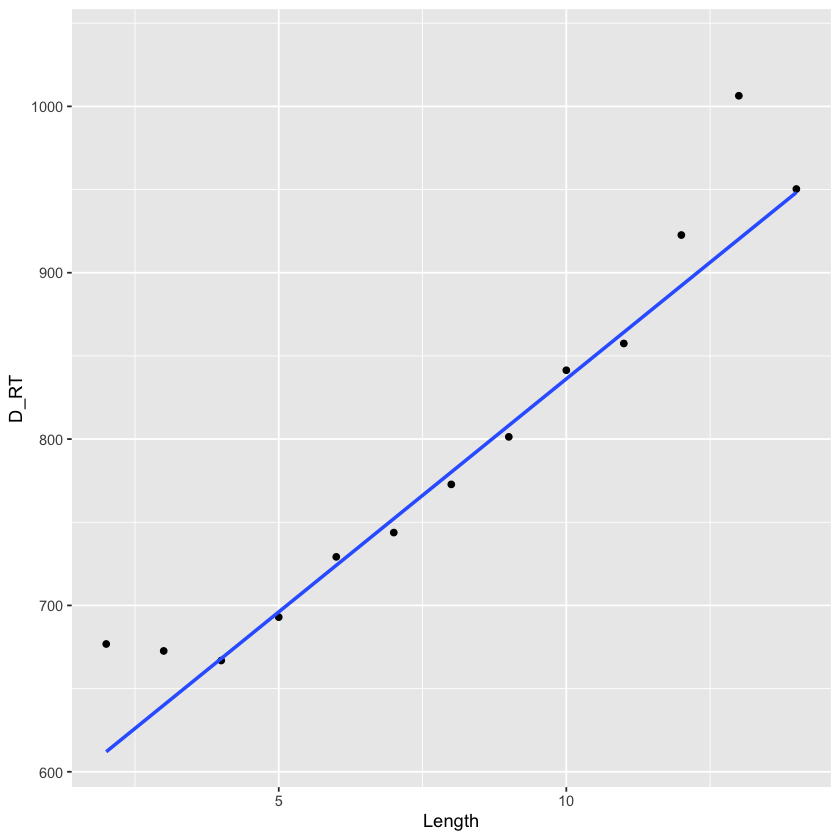

In [15]:
ggplot(df1, aes(Length, D_RT)) +
    stat_summary(geom='point') +
    geom_smooth(method='lm', se=F)

Now, let's see how much this effect varies across participants. Make the same plot, but this time in the `aes()` function add the argument `color=Sub_ID`. This will create separate regression lines in different colors for each participant.

No summary function supplied, defaulting to `mean_se()



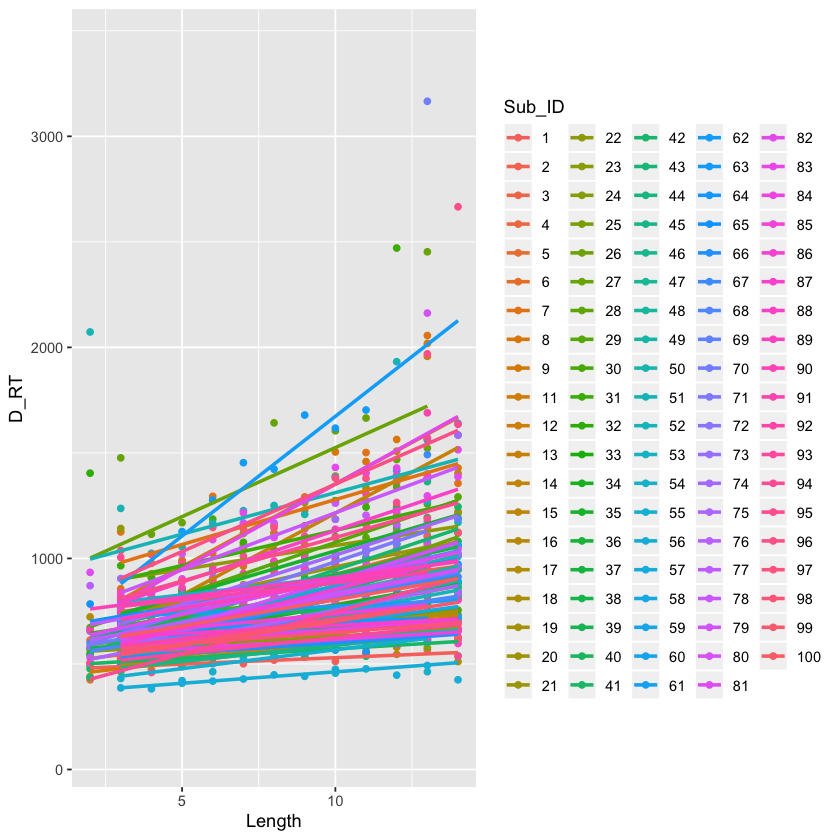

In [16]:
ggplot(df1, aes(Length, D_RT, color=Sub_ID)) +
    stat_summary(geom='point') +
    geom_smooth(method='lm', se=F)

Describe briefly the plot above. What stands out to you?

> A lot of subjects show similar effects of wordlength on reaction time. Basically every regression line shows an increase of reactiontime based on wordlength. But there are still some subject showing a relatively greater effect of wordlength on reaction time (see blue line above). One can also see, that the subjects have different basic "abilities/manners" to react (see different starting point of regression lines, different intercepts.)

The plot above has too many subjects so it's a bit difficult to see them well. Just for the exercize, let's do the same plot but for a smaller subset of subjects. Filter the data so that you keep only data for subjects 8,13,50,56,62,78,82 and repeat the plot above with this filtered dataset. Which of these subjects has the lowest intercept? Which one seems to have the steepest slope?

Hint: In order to filter the data, you can try the following:
- specify a new variable called `included_subjects = c(8, 13, 50)`, where you can add as many subject numbers as you want between the brackets.. Then, in the filter command you can do `filter(df1, Sub_ID %in% included_subjects)`

No summary function supplied, defaulting to `mean_se()



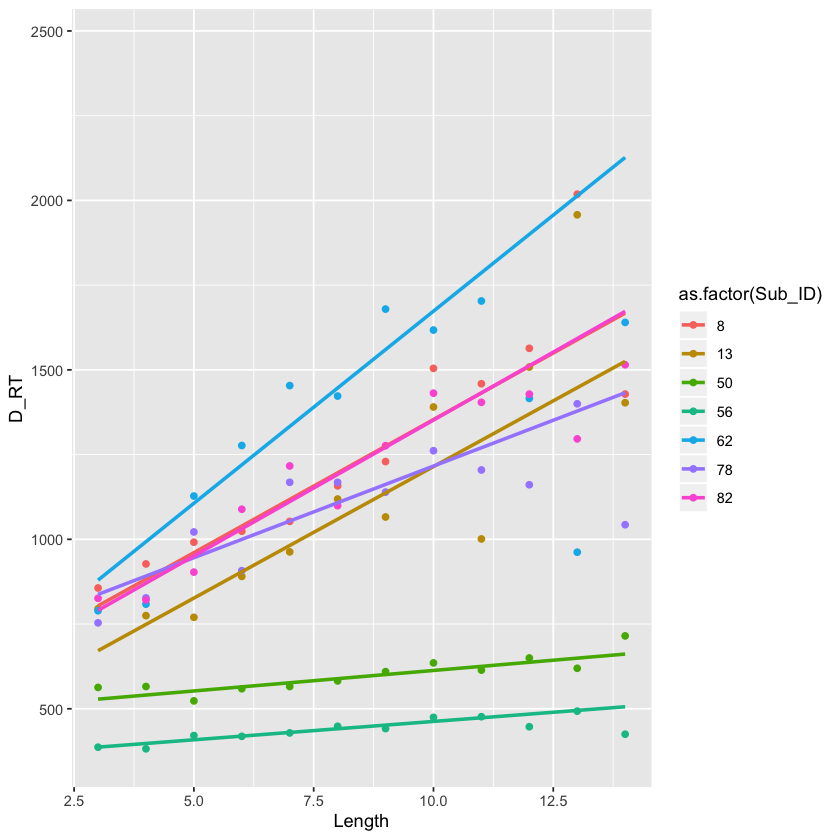

In [18]:
included_subjects = c(8,13,50,56,62,78,82)

filter(df1, Sub_ID %in% c(8,13,50,56,62,78,82))  %>% 
ggplot(aes(Length, D_RT, color=as.factor(Sub_ID))) +
    stat_summary(geom='point') +
    geom_smooth(method='lm', se=F)

> The plot shows, that subject number 56 has the lowest intercept (approximatly 250). It seems that subject number 62 has the steepest slope. 

#### Part 3: Fit separate linear regression to each subject

Before we fit a mixed-effects model, let's pretend that each subject is it's own experiment and let's fit a separate linear regression for each subject. We will then extract the intercepts and slopes for each participant's regression, and plot their distribution. The next few cells will take you step by step through this process

Create a new variable called `sub_ids` that contains the unique values of Sub_ID. This variable should have 99 unique values (you can use the `unique()` command):

In [19]:
sub_ids <- unique(df1$Sub_ID)
sub_ids
length(sub_ids)

[1] 85  21  29  51  83  86  64  57  48  43  55  49  39  38  95  94  93  77  8  
[20] 14  52  100 92  99  98  91  90  89  88  87  84  82  70  67  97  96  59  1  
[39] 3   81  80  79  78  76  75  74  73  72  71  69  68  66  65  63  62  61  60 
[58] 28  27  26  25  24  23  22  20  19  18  17  16  15  13  12  11  9   7   6  
[77] 5   4   2   37  36  35  34  33  32  31  30  58  56  54  53  50  47  46  45 
[96] 44  42  41  40 
99 Levels: 1 2 3 4 5 6 7 8 9 11 12 13 14 15 16 17 18 19 20 21 22 23 24 ... 100

[1] 99

Now we need to create a `for` loop that will fit a regression separately for each participant. We can do that step by step. Please read https://www.datacamp.com/community/tutorials/tutorial-on-loops-in-r if you are not familiar with how `for` loops work. We will create the following basic algorithm:

1. Create an empty variable to store the intercepts for each subject
2. Create an empty variable to store the slopes for each subject
3. [Loop] - for each value of sub_ids:
    - Extract the data for that subject and assign it to a temporary variable
    - Fit a regression model to the extracted data and assign the output to a temporary variable
    - Extract the intercept from the model variable, and append it to the empty intercept variable we created before
    - Extract the slope from the model variable and append it to the empty slope variable we created before

Since this is a fairly advanced use of R programming, the basic code for this is provided below, but you need to fill out some missing details:
- You will need to replace the `df1` variable with the name of your main data.frame that contains data for all subjects
- In the line `sub_ml <- ` add a linear regression of D_RT as a function of Length. Use the `sub_data` in the linear regression call as an argument for `data = `


Then run the cell below:

In [20]:
sub_intercepts <- c() # create an empty variable to store the intercepts for each subject
sub_slopes <- c() # create an empty variable to store the slopes for each subject

# loop over sub_id values
for (subject in sub_ids) {
    sub_data <- filter(df1, Sub_ID == subject)  # extract data for the subject in each loop step
    sub_ml <- lm(D_RT ~ Length, data=sub_data)  # run a regression for each subjects data
    intercept <- coef(sub_ml)[1] # extract the intercept for the subject in each loop step
    slope <- coef(sub_ml)[2] # extract the slope for the subject in each loop step
    sub_intercepts <- c(sub_intercepts, intercept) # append the intercept of this subject to the vector of intercepts for each subject
    sub_slopes <- c(sub_slopes, slope) # append the intercept of this subject to the vector of intercepts for each subject
}

Now, both `sub_intercepts` and `sub_slopes` should be vectors with 99 values each. Show their contents in the cell below:

In [28]:
print(sub_intercepts)
print(sub_slopes)
length(sub_intercepts)
length(sub_slopes)

(Intercept) (Intercept) (Intercept) (Intercept) (Intercept) (Intercept) 
   598.5258    644.0770    576.8080    917.9777    551.6018    484.7978 
(Intercept) (Intercept) (Intercept) (Intercept) (Intercept) (Intercept) 
   475.4451    515.4921    521.6647    605.1807    388.4301    420.9655 
(Intercept) (Intercept) (Intercept) (Intercept) (Intercept) (Intercept) 
   451.0546    596.8696    686.9982    347.7834    472.2959    631.4396 
(Intercept) (Intercept) (Intercept) (Intercept) (Intercept) (Intercept) 
   568.0956    440.0401    469.7841    555.6093    526.0888    475.1205 
(Intercept) (Intercept) (Intercept) (Intercept) (Intercept) (Intercept) 
   536.7933    724.2329    723.2109    636.2695    643.8519    607.0846 
(Intercept) (Intercept) (Intercept) (Intercept) (Intercept) (Intercept) 
   528.5795    549.8217    531.3688    512.0511    483.8682    713.6031 
(Intercept) (Intercept) (Intercept) (Intercept) (Intercept) (Intercept) 
   460.0240    469.1171    538.9481    572.3177    

[1] 99

[1] 99

Let's combine `sub_ids`, `sub_intercepts` and `sub_slopes` in a new data.frame with 3 columns named `id`, `intercept` and `slope` that correspond to each of these variables. The data.frame should have 99 rows, one row for each subject. Assign the result to a new variable called `sub_lm_coefs` and show it's contents:

In [29]:
sub_lm_coefs <- data.frame(id=sub_ids, intercept = sub_intercepts, slope = sub_slopes)
sub_lm_coefs

id,intercept,slope
<fct>,<dbl>,<dbl>
85,598.5258,13.941779
21,644.0770,31.577920
29,576.8080,49.909414
51,917.9777,39.384502
83,551.6018,11.191614
86,484.7978,36.937776
64,475.4451,33.357248
57,515.4921,31.262975
48,521.6647,31.405133


Use the `arrange()` command from the `tidyverse` package to sort the data frame first by the intercept and then by the slope. Answer the following questions:
- which subject has the slowest and which has the fastest intercept?
- which subject has the steepest and the least steep slope? Explain their slope values in terms of how word length affects RTs
- are there any subject for which Length affects RTs negatively?

In [30]:
arrange(sub_lm_coefs, intercept)

id,intercept,slope
<fct>,<dbl>,<dbl>
94,347.7834,39.886670
56,354.3454,10.827716
55,388.4301,17.882297
26,390.4092,50.847820
49,420.9655,33.847135
11,428.7327,16.406302
45,435.8119,15.198436
4,438.4972,20.432028
13,438.5252,77.602536


> Subject 94 has the fastest intercept (347.7834). Subject 51 has the slowest intercept (917.9777).

In [31]:
arrange(sub_lm_coefs, slope)

id,intercept,slope
<fct>,<dbl>,<dbl>
1,469.1171,6.055492
63,635.0193,6.290070
61,703.2857,7.015212
72,585.4562,7.498995
87,607.0846,7.577499
24,515.9155,8.032788
41,484.1498,8.717047
84,528.5795,8.740112
23,542.5200,8.839516


> Subject 1 has the least steep slope (6.055492), meaning the reaction time increases by 6ms per each letter added to a word. Subject 62 has the steepest slope (113.37023), meaning the reaction time increases by 113 ms per each letter added to a word.
> No, there are no subject showing negative effects of wordlength on reaction time.

Make 3 plots:
- A histogram of the intercepts for each participant
- A histogram of the slopess for each participant
- A scatterplot of the relationship between intercepts and slopes for each participant

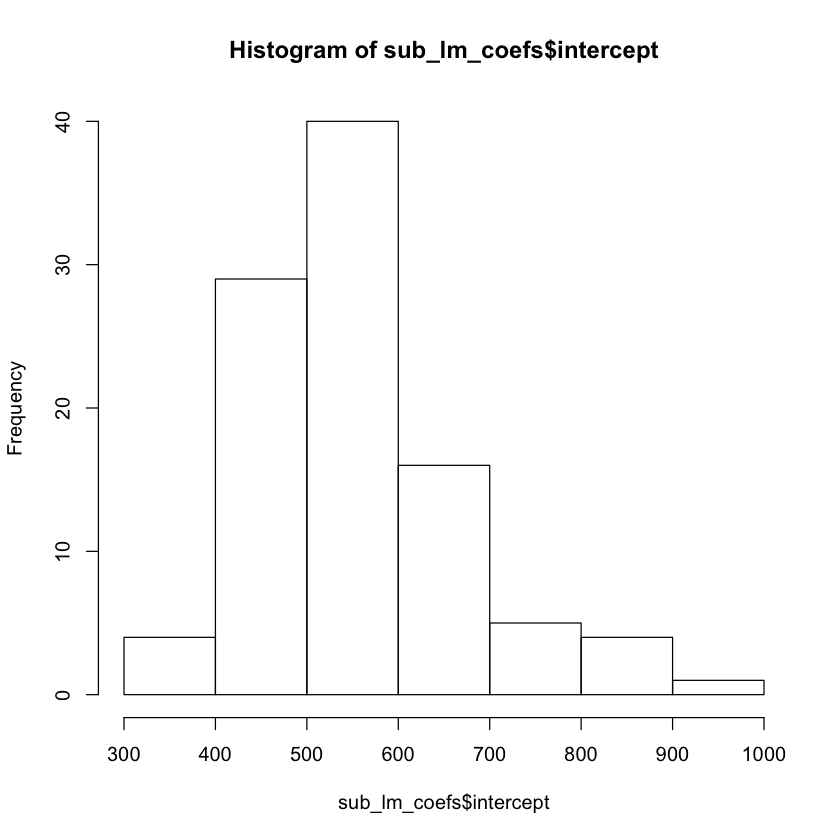

In [33]:
hist(sub_lm_coefs$intercept)

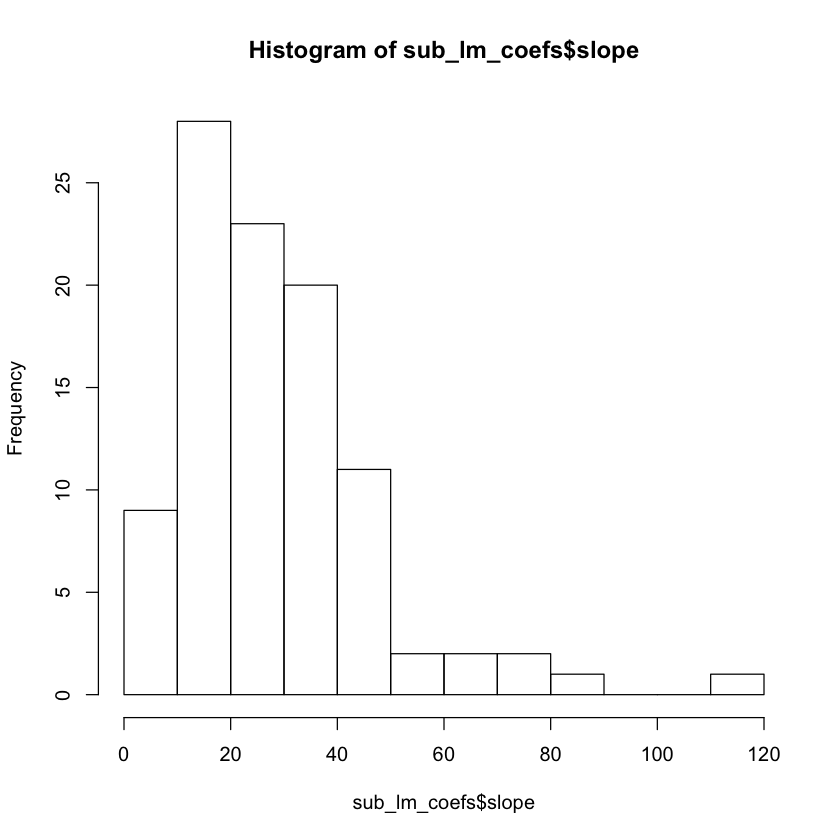

In [34]:
hist(sub_lm_coefs$slope)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



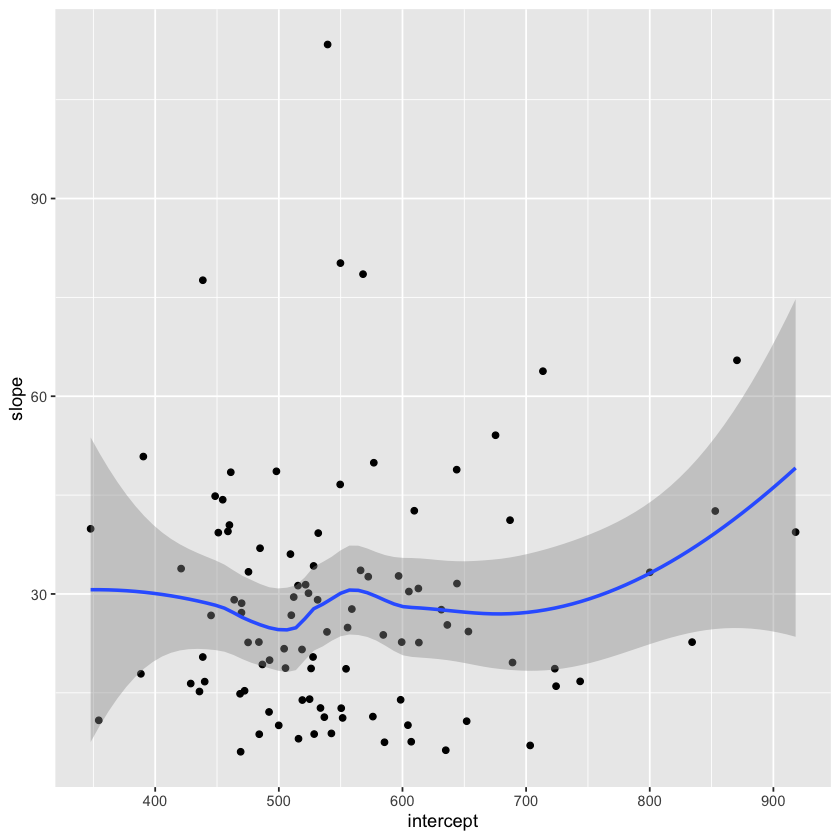

In [35]:
ggplot(sub_lm_coefs, aes(intercept, slope)) +
    geom_point() +
    geom_smooth()

Are the intercepts and slopes normally distributed across subjects?

> No, it seems they are not totally normally distributed. Both distributions are left-steep and right-skew, because some subjects have extreme values. 

Are the intercept and slope for each subject correlated? That is, if the subject is overall slower in the task, are they more strongly affected by the word length property?

In [36]:
cor.test(sub_lm_coefs$intercept, sub_lm_coefs$slope)


	Pearson's product-moment correlation

data:  sub_lm_coefs$intercept and sub_lm_coefs$slope
t = 0.77277, df = 97, p-value = 0.4415
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1210587  0.2714427
sample estimates:
       cor 
0.07822247 


> Looking at the plot, it doesn't seem that the intercept and slope for each subject are correlated. Doing a correlation test, confirms this assumption. 

What is the mean intercept and slope over all participants?

In [39]:
mean(sub_lm_coefs$intercept)
mean(sub_lm_coefs$slope)

[1] 553.263

[1] 28.5922

#### Part 4: Fit a mixed-effects regression to the data

We just fit a separate regression model to the data from each participant, ignoring the data from other participants. This accounts for individual differences, but it has several drawbacks:
- it is not easy to test directly whether overall the effect of word length has an effect of RTs. The fact that all subjects showed positive slopes is an indication that this effect is overall present, but we need a more systematic way to do this
- in fitting the data of each subject, we completely ignore data from other subjects. Even though individual differences are expected, it is also reasonable to expect that people cognitive processes are similar. Thus, we are throwing away a lot of data when doing this, because we assume that one participants' parameters are not informed by data from other participants. Since we have a limited number of observations per participant, the individual parameter estimates will be more noise and more easily affected by outliers. This can lead to a biased estimation.

Both of these drawbacks can be overcome by fitting a mixture effects regression, which is a compromise between completely pooling the data, which ignores individual differences (e.g., Homework 4), and the completely separate regression for each participant, which ignores commonalities between participants and throws away data.

First, install and load the `lme4` package, which allows us to fit mixed effects regressions:

In [40]:
library(lme4)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




Now, use the `lmer()` command to fit a simple mixed-effects linear regression model with only random intercepts for each participant (consult the tutorials you read last week for how to do this. This should be a basic regression of D_RT with only an intercept. You can use the formula `D_RT ~ 1 + (1|Sub_ID)`. Save the output to a variable called `mixed_ml0` and use the `summary()` command to display the results

In [41]:
mixed_ml0 <- lmer(D_RT ~ 1 + (1|Sub_ID), data=df1)
summary(mixed_ml0)

Linear mixed model fit by REML ['lmerMod']
Formula: D_RT ~ 1 + (1 | Sub_ID)
   Data: df1

REML criterion at convergence: 518736.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1054 -0.4849 -0.1790  0.2266 10.3937 

Random effects:
 Groups   Name        Variance Std.Dev.
 Sub_ID   (Intercept)  28990   170.3   
 Residual             105643   325.0   
Number of obs: 35978, groups:  Sub_ID, 99

Fixed effects:
            Estimate Std. Error t value
(Intercept)    749.1       17.2   43.56

This simple model does not have predictors. In this case, the Intercept is merely the mean RTs overall, or what we would expect the RTs to be if all predictors are set to their mean value.

Now, let's add the effect of word length as a fixed effect to the formula. Save the results to a variable `mixed_ml1` and use `summary(mixed_ml1)` to display the results

In [42]:
mixed_ml1 <- lmer(D_RT ~ Length + (1|Sub_ID), data=df1)
summary(mixed_ml1)

Linear mixed model fit by REML ['lmerMod']
Formula: D_RT ~ Length + (1 | Sub_ID)
   Data: df1

REML criterion at convergence: 517301.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1864 -0.4869 -0.1754  0.2305 10.5000 

Random effects:
 Groups   Name        Variance Std.Dev.
 Sub_ID   (Intercept)  29082   170.5   
 Residual             101507   318.6   
Number of obs: 35978, groups:  Sub_ID, 99

Fixed effects:
            Estimate Std. Error t value
(Intercept) 555.0728    17.9537   30.92
Length       28.3131     0.7403   38.25

Correlation of Fixed Effects:
       (Intr)
Length -0.283

What are the overall intercept and slope for Length? How do you interpret these values?

> The model shows an intercept of 555.0728, meaning reaction time is on average equal 555.0728 for wordlength = 0.
> The model shows an overall slope of 28.3131 for Length, meaning an average increase in reactiontime (across all participants) of 28.3131, when wordlength is increased by one letter.

As you notice, there are no p-values in this output. We can use the command "anova(mixed_ml0, mixed_ml1) to perform a likelihood ratio test, and to use the Aikaike Information Criterion (AIC) to see if the mixed_ml1 model fits the data better than the mixed_ml0 model:

In [43]:
anova(mixed_ml0, mixed_ml1)

refitting model(s) with ML (instead of REML)



,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mixed_ml0,3,518749.7,518775.2,-259371.9,518743.7,NA,NA,NA
mixed_ml1,4,517318.0,517351.9,-258655.0,517310.0,1433.755,1,9.716528e-314


You see that the output has two rows, one for each model. The `npar` column shows the number of parameters in the model. The AIC and BIC columns show two different indices of model fit. The best fitting model is the one with the lowest AIC. If the more complex model (ml1) has an AIC that is lower by more than 2 than the next best fitting model, we can conclude that including the Length variable improves the model. The table also provides a p-value (in scientific number notation) for the comparison between models. In this case, mixed_ml1 fits significantly better than the mixed_ml0, so word length improves the model fit and should be kept

We have only fit random intercepts for each subject, which assumes that each subject has a different baseline of RTs, but that each subject is affectedf similarly by word Length. You can extract the random effect parameters for each subject with the following command:

In [44]:
ml1_coefs <- coef(mixed_ml1)$Sub_ID
names(ml1_coefs) <- c('intercept','slope')
ml1_coefs

,intercept,slope
,<dbl>,<dbl>
1,316.7377,28.31307
2,629.7282,28.31307
3,511.6176,28.31307
4,386.3402,28.31307
5,424.8326,28.31307
6,605.3286,28.31307
7,948.2089,28.31307
8,920.7357,28.31307
9,427.7914,28.31307


This table is similar to the one we constructed manually from the separate regressions; however, the slope is the same for all participants. Let's fit the model again, this time by including random slopes for Length. You can do that with the formula `D_RT ~ Length + (Length|Sub_ID)`. Save the result to the `mixed_ml2` variable and show the results using `summary()`

In [45]:
mixed_ml2 <- lmer(D_RT ~ Length + (Length|Sub_ID), data=df1)
summary(mixed_ml2)

Linear mixed model fit by REML ['lmerMod']
Formula: D_RT ~ Length + (Length | Sub_ID)
   Data: df1

REML criterion at convergence: 516889.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4823 -0.4734 -0.1762  0.2231 10.5560 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 Sub_ID   (Intercept)   8728.8  93.43       
          Length         277.2  16.65   0.34
 Residual             100109.4 316.40       
Number of obs: 35978, groups:  Sub_ID, 99

Fixed effects:
            Estimate Std. Error t value
(Intercept)  553.482     10.791   51.29
Length        28.560      1.828   15.62

Correlation of Fixed Effects:
       (Intr)
Length 0.085 

What are the overall intercept and slope for Length? Have they changed much relative to the model without a random slope?

> The overall slope for Length changed from 28.3131 (mixed_ml1) to 28.560 (mixed_ml2), resulting in a very small change. 
> The intercept changed from 555.0728 (mixed_ml1) to 553.482 (mixed_ml2), also resulting in a small change.

You can use the `anova()` command again to test whether the random effect improves the model fit:

In [46]:
anova(mixed_ml1, mixed_ml2)

refitting model(s) with ML (instead of REML)



,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mixed_ml1,4,517318.0,517351.9,-258655.0,517310.0,NA,NA,NA
mixed_ml2,6,516911.4,516962.4,-258449.7,516899.4,410.5322,2,7.146141e-90


Now, finally, let us extract the random effects from this model, and compare them to the separate intercept and slopes we fit to each participant in the previous part. First, use the `coef()` command on the final model, and save the output to a variable called `mixed_lm_coefs`. Repeat all steps I showed you above in order to rename the columns with more useful names

In [47]:
mixed_lm_coefs <- coef(mixed_ml2)$Sub_ID
names(mixed_lm_coefs) <- c('intercept','slope')
mixed_lm_coefs

,intercept,slope
,<dbl>,<dbl>
1,463.2894,7.148121
2,642.5158,26.002231
3,537.3889,24.513066
4,456.8131,18.114820
5,492.8140,18.652682
6,550.4832,36.576596
7,789.4494,50.779813
8,626.1566,70.376563
9,518.7866,14.910488


Repeat the plots we made in the previous part, this time using the mixed-effects random effects:
- A histogram of the intercepts for each participant
- A histogram of the slopess for each participant
- A scatterplot of the relationship between intercepts and slopes for each participant

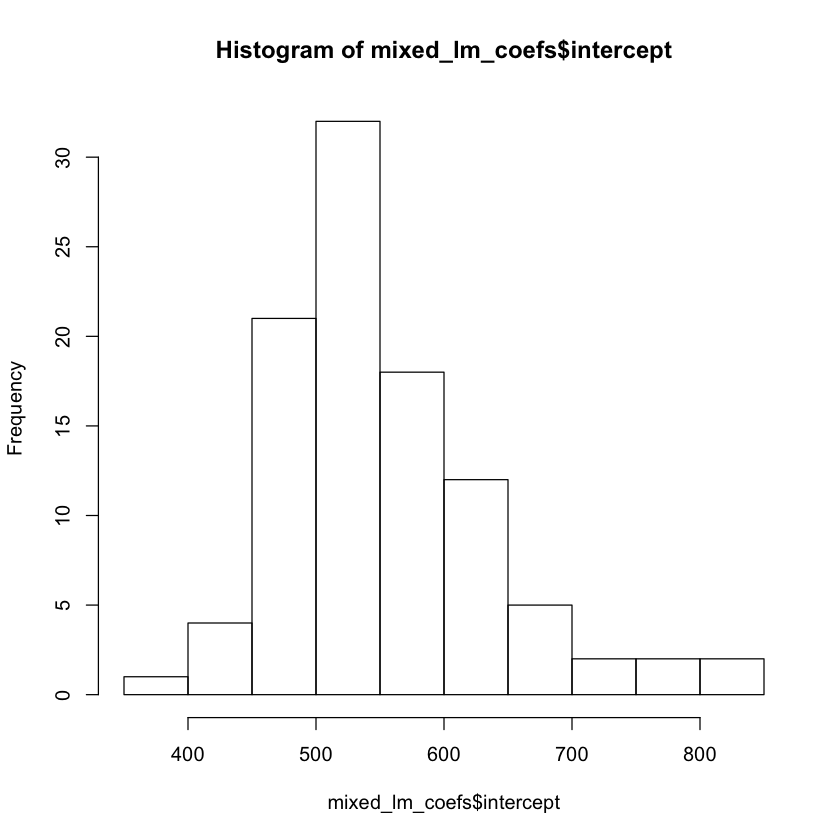

In [53]:
hist(mixed_lm_coefs$intercept)

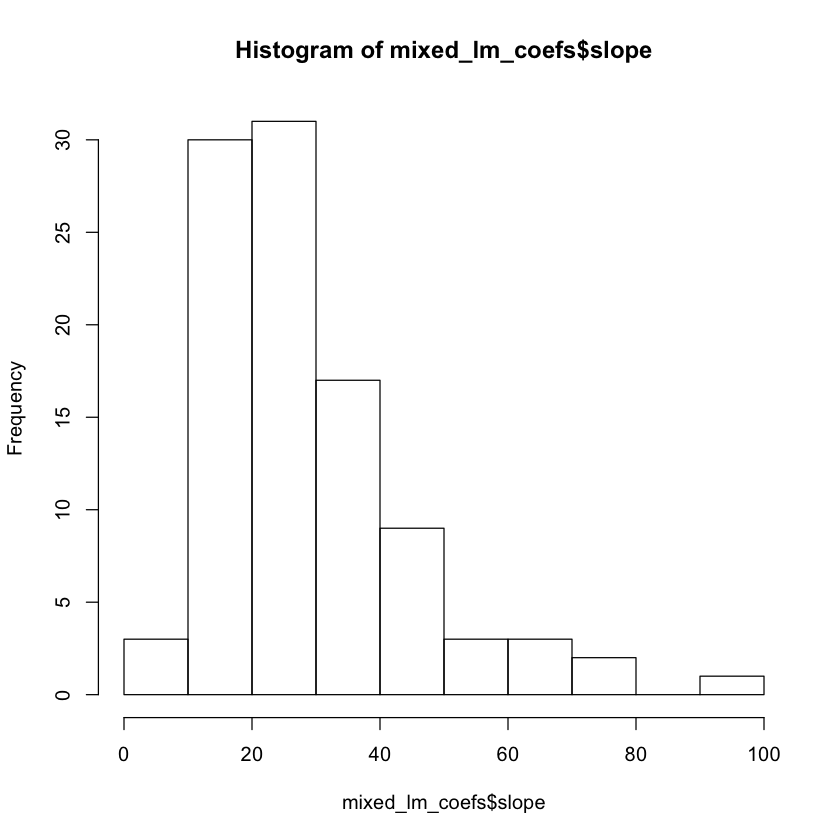

In [50]:
hist(mixed_lm_coefs$slope)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



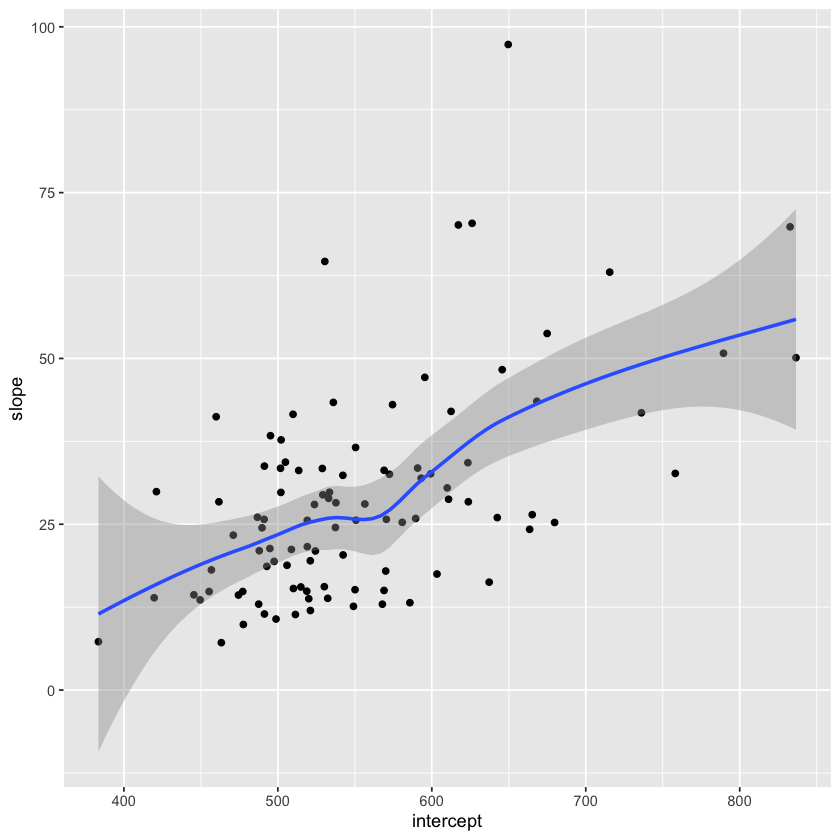

In [52]:
ggplot(mixed_lm_coefs, aes(intercept, slope)) +
    geom_point() +
    geom_smooth()

What differences do you notice relative to the plots for the separately fit regressions? Pay attention to the values on the x-axis for the histograms. Why do you think these differences occur?

> There's a difference in the expression of extreme values in both plots, for intercept and slope. The tendency of a correlation of intercepts and slopes is more pronounced when using the mixed-effects random effects. It's different because now we used all the data from all subjects while applying mixed-effects models. Having more subjects, means more observations, leading to less variation/less extreme values and in the end leading to clearer effects.

In the next couple of plots, I'm plotting the parameter estimates from the mixed effects model relative to the parameter estimates from the separate by-subject regressions. Each dot is a participant. The black line represents a diagonal on which parameter estimates would be equal in the two models - points under the diagonal have smaller parameter estimates in the mixed-effects model. Points above the diagonal have a larger parameter estimates in the mixed-effects regression relative to the separate by-subject regressions. What are the main patterns you notice in these plots? Can those patterns help you answer the previous question?

New names:
* intercept -> intercept...2
* slope -> slope...3
* intercept -> intercept...4
* slope -> slope...5



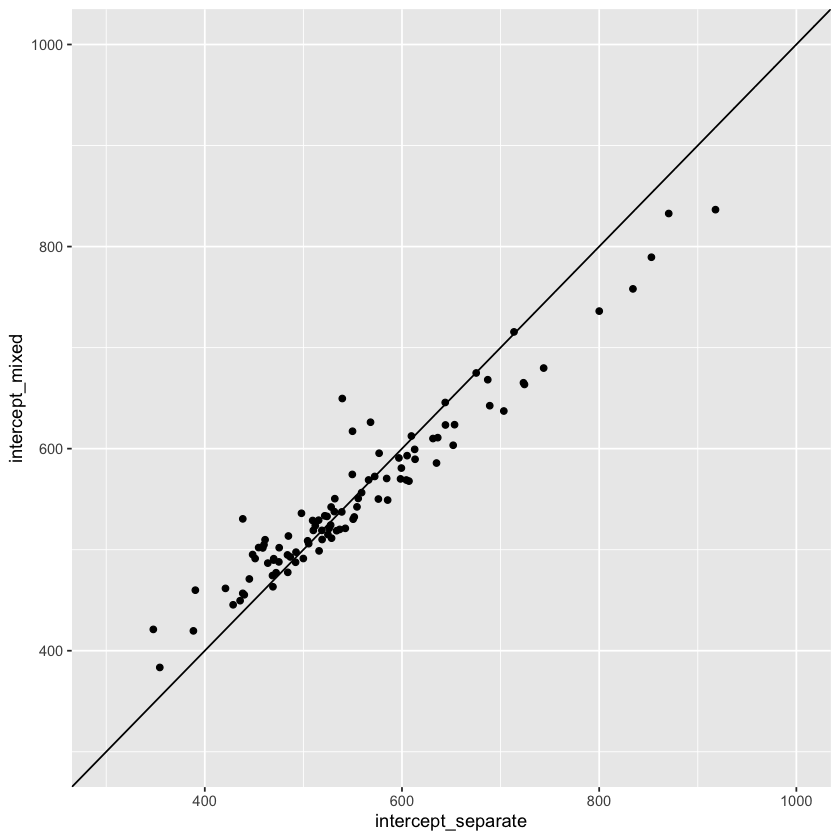

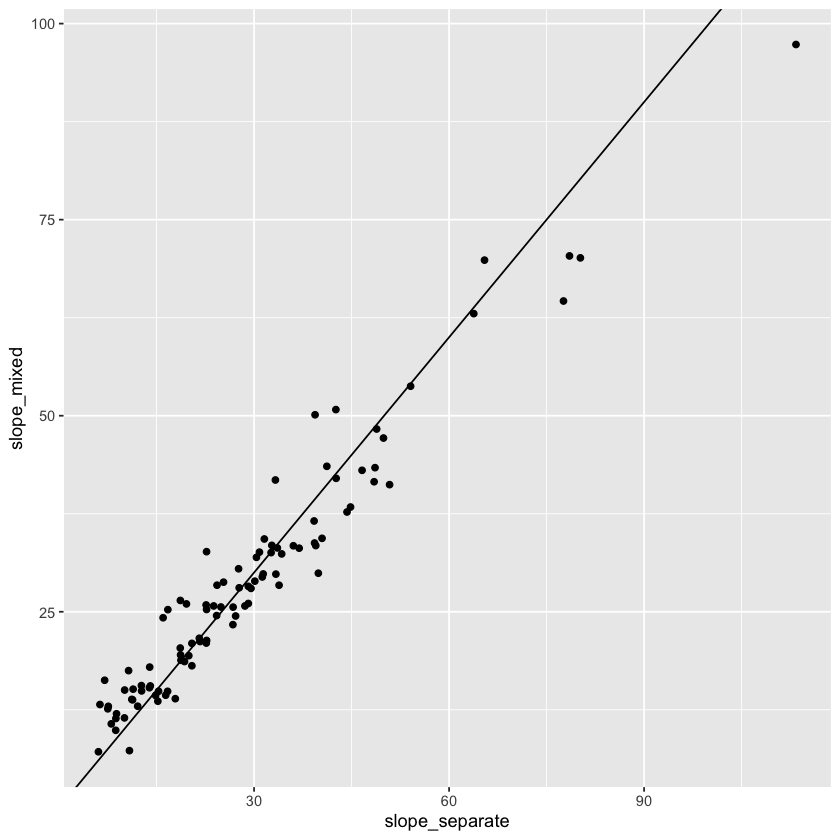

In [54]:
sub_lm_coefs <- arrange(sub_lm_coefs, id)
both_coefs <- bind_cols(sub_lm_coefs, mixed_lm_coefs)
names(both_coefs) <- c('id','intercept_separate','slope_separate', 'intercept_mixed','slope_mixed')

ggplot(both_coefs, aes(intercept_separate, intercept_mixed)) +
    geom_point() +
    geom_abline(intercept=0, slope=1) +
    coord_cartesian(xlim=c(300,1000), ylim=c(300, 1000))


ggplot(both_coefs, aes(slope_separate, slope_mixed)) +
    geom_point() +
    geom_abline(intercept=0, slope=1) 


> Yes, I think these plotted parameter estimates help to answer the previous question! It looks like the estimates are closer to the mean parameter (closely under the diagonal) in the mixed-effects regression compared to the separate by-subject regression. On the other hand, in case of small parameter estimates they get increased applying a mixed-effects regression, bringing them closer to the mean parameter, but above the line.
This is, because in a mixed-effects regression we consider all the different subjects with their individual reaction times (random effects?).